In [99]:
"""Import everything we need"""
already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73
    !pip install tqdm
    !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
    !apt install texlive-science

import matplotlib
import os
import random
import mat73
import scipy.io
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
from tensorflow.math import abs, angle, real, imag, subtract, multiply
from scipy.special import binom
from matplotlib import rc
from scipy.stats import chi2, betaprime, norm
from scipy.optimize import minimize
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tqdm import tqdm
from math import factorial

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}', r'\usepackage{siunitx}', r'\usepackage{lipsum}']

In [100]:
#@title
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape=[64,64]):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

In [101]:
#@title
def is_arithmetic(l):
    for index in range(len(l) - 1):
        if not (l[index + 1] - l[index] == 1):
            is_arithmetic.counter += 1
            return False
    return True

def extract_pos_and_images(data, shortest_trace=20):
    """Saves images and positions for individual particles."""
    is_arithmetic.counter = 0
    particles_timeseries = []
    particles_positions = []
    num_particles = data.shape[1]

    for i in tqdm(range(num_particles)):
        roi_data = np.array(data[0,i][0,0]["ROI"])
        if shortest_trace <= roi_data[0,0].shape[0] and is_arithmetic(data[0,i][0,0]["Positions"][:,0].flatten()):
            positions = data[0,i][0,0]["Positions"][:,1:4]
            particles_positions.append(positions)

            timeseries = []

            for j in range(roi_data[0,0].shape[0]):
                particleROI = np.expand_dims(np.fft.fftshift(np.fft.ifft2(exp_expand(roi_data[0,0][j,:]))), axis = -1)
                timeseries.append(particleROI)
            particles_timeseries.append(np.array(timeseries))
    print(f"Number of traces discarded because of non-constant time-steps: {is_arithmetic.counter}")
    return particles_positions, particles_timeseries

In [102]:
def create_group(crop_size=64, padding=16, wavelength=525e-9, pixel_size=114e-9):
    crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size, wavelength)
    crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size, wavelength)

    args = dt.Arguments(
        translate=lambda: np.random.randn(2)*0.5,
        rotate=lambda: np.random.uniform(0, np.pi*2),
        z=lambda: np.random.randn(1)*20,
    )

    group = ( 
        dt.Affine(rotate=args.rotate) 
        >> dt.Affine(translate=args.translate) 
        >> dt.FourierTransform(padding=padding) 
        >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z, padding=padding) 
        >> dt.InverseFourierTransform(padding=padding) 
    )

    equivariance = (
        dt.models.lodestar.Rotational2DEquivariance(args.rotate)
        >> dt.models.lodestar.TranslationalEquivariance(args.translate)
        >> dt.models.lodestar.Equivariance(1, args.z/10, indexes=2)
    )

    return group, equivariance, (crop_propagation_forward, crop_propagation_backward)

def create_training_set(particles_timeseries):
    imgs = []
    for particle_id in range(0,len(particles_timeseries),1):
        img = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        img = img[0,:,:,:]
        imgs.append(img)
    return dt.Value(lambda: random.choice(np.array(imgs)))

def plot_dataset(dataset, group, nrows=3, ncols=10):
    for _ in range(nrows):
        fig, axs = plt.subplots(1,ncols,figsize=(25,8))
        for i in range(ncols):
          axs[i].imshow((dataset>>group).update()()[..., 1])
        plt.show()


In [103]:
#@title
"""Create custom layers"""
class CustomLayer(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [104]:
#@title
"""Create models"""
def create_model(custom_layer, num_layers, image_size, num_outputs):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(image_size,image_size,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(64, 3, activation='relu', strides=(2,2)))
    for _ in range(num_layers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": num_layers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model


In [105]:
#@title
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = cycler(color=list('bgrcmyk'))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()


In [106]:
#@title
def get_propagation_matrix(shape, to_z, pixel_size, wavelength):

    k = 2 * np.pi / wavelength
    yr, xr, *_ = shape

    x = 2 * np.pi / pixel_size * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / pixel_size * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return C * np.fft.fftshift(np.exp(k * 1j * to_z * (K - 1)))

def fourier_transform(image, padding=32):
    im = np.pad(image, ((padding, padding), (padding, padding)), mode="symmetric")
    return np.fft.fft2(im)

def inverse_fourier_transform(image, padding=32):
    im = np.fft.ifft2(image)
    return im[padding:-padding, padding:-padding]

def fourier_transform_transformation(image, Tz, Tzinv, i):
    if i < 0:
        image *= Tzinv ** np.abs(i)
    else:
        image *= Tz ** i
    return image

def propagate(image, z, prop_matrices, padding):
    """Re-propagate the images using PAS"""
    crop_propagation_forward, crop_propagation_backward = prop_matrices
    ft_image = fourier_transform(image[:,:,0], padding=padding)
    prop_ft_image = fourier_transform_transformation(ft_image, crop_propagation_backward, crop_propagation_forward, -z)
    return np.expand_dims(inverse_fourier_transform(prop_ft_image, padding=padding),axis=-1)

In [107]:
#@title
def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets, val_stack.shape[2])
    return dets

def reshape_dets(dets, image_size):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = image_size//2, image_size//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            print("DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.")
            out.append([0,0,0])
    return np.array(out)

def create_validation_stack(images, z_list, prop_matrices, padding):
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z, prop_matrices, padding))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]

def evaluate_model(model, val_stack, prop_range):
    accs=[]
    for i in range(min(val_stack.shape[0], 15)):
        acc = np.array([predict_on_stack(model, val_stack[i])[:,2]])
        acc = acc - np.mean(acc)
        accs.append(acc)
    accs = np.array(accs)

    fig, axs = plt.subplots(1,2, figsize=(16,6))
    for i in range(accs.shape[0]):
        axs[0].plot(prop_range/10, prop_range/10, 'k')
        axs[0].plot(accs[i,:].flatten(), prop_range/10, '-.')
        axs[0].set_title("Numeriskt ompropagerade bilder", fontsize=20)
        axs[0].set_xlabel(r"Predikterat avstånd [\SI{}{\micro\meter}]", fontsize=16)
        axs[0].set_ylabel(r"Propagerat avstånd [\SI{}{\micro\meter}]", fontsize=16)
        axs[0].set_xticks(np.linspace(prop_range[0], prop_range[-1], 9)/10)
        axs[0].set_yticks(np.linspace(prop_range[0], prop_range[-1], 9)/10)
        axs[0].grid(True)

    for i in range(accs.shape[-1]):
        axs[1].scatter((prop_range/10)[i], np.std(accs[:,:,i]), c="r", marker="x")
        axs[1].set_title("Numeriskt ompropagerade bilder", fontsize=20)
        axs[1].set_xlabel(r"Standardavvikelse i predikterat avstånd [\SI{}{\micro\meter}]", fontsize=16)
        axs[1].set_ylabel(r"Propagerat avstånd [\SI{}{\micro\meter}]", fontsize=16)
        axs[1].set_xticks(np.linspace(prop_range[0], prop_range[-1], 9)/10)
        axs[1].grid(True)
    plt.show()

def plot_consistency(model, validation_set, prop_range, prop_matrices, padding):
    val_stack = create_validation_stack(validation_set, prop_range, prop_matrices, padding)
    evaluate_model(model, val_stack, prop_range)

In [108]:
#@title
def calc_sigma2(arr):
    sigma2 = -np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            ))
    return sigma2

In [109]:
def train_on_particle(model, particle, num_outputs, group, equivariance, epochs, verbose=0):
    training_set = create_training_set(particle)

    generator = dt.models.lodestar.LodeSTARGenerator(
        training_set,
        num_outputs=num_outputs, 
        transformation_function=(group, equivariance), 
        batch_size=8, 
        min_data_size=100, 
        max_data_size=101,
    )

    const = 10
    for _ in tqdm(range(epochs//const)):
        with generator:
            h = model.fit(generator, epochs=const, steps_per_epoch=100, verbose=verbose)

def compare_lode_matlab(model, particles, particles_positions,  verbose=1):
    z_mults = []
    traces_matlab = []
    traces_new = []

    for particle_id in tqdm(range(len(particles))):

        timeseries = np.stack((np.real(particles[particle_id][:,:,:,0]), np.imag(particles[particle_id][:,:,:,0])), axis=-1)
        corrections = predict_on_stack(model, timeseries)

        x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
        x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2]*1.56

        z_lode = z_lode - np.mean(z_lode)
        x_new, y_new, z_new = x_matlab+(x_lode-32)*0.114, y_matlab+(y_lode-32)*0.114, z_matlab+z_lode # byt ut mot pixel_sizez!

        z_mult = minimize(lambda x: np.abs(calc_sigma2(z_matlab + z_lode*x)), [0], method="Powell").x
        z_mult = np.median([-10,z_mult,10]) #reducing the effect of very strange values

        if verbose:
            #print("PARTICLE ID:", particle_id, end="  ")
            #print(f"z_mult: {z_mult:.3f}, sigma2_new/sigma2_matlab: {calc_sigma2(z_new)/calc_sigma2(z_matlab):.2f}")

            if particle_id%100==0:
                fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24,6))

                t_range = np.linspace(0, len(z_new)/41, len(z_new))
                ax1.grid(True)
                ax1.set_ylabel(r"x-koordinat [\SI{}{\micro\meter}]", fontsize=16)
                ax1.set_xlabel(r"Tid [\SI{}{\second}]", fontsize=16)
                ax1.plot(t_range, x_matlab, 'b')
                ax1.plot(t_range, x_new, 'r')

                ax2.grid(True)
                ax2.set_ylabel(r"y-koordinat [\SI{}{\micro\meter}]", fontsize=16)
                ax2.set_xlabel(r"Tid [\SI{}{\second}]", fontsize=16)
                ax2.plot(t_range, y_matlab, 'b')
                ax2.plot(t_range, y_new, 'r')
                ax2.legend(["matlab", "lode"])

                ax3.grid(True)
                ax3.set_ylabel(r"z-koordinat [\SI{}{\micro\meter}]", fontsize=16)
                ax3.set_xlabel(r"Tid [\SI{}{\second}]", fontsize=16)
                ax3.plot(t_range, z_matlab, 'b')
                ax3.plot(t_range, z_new, 'r')
                plt.show()

        z_mults.append(z_mult)
        traces_matlab.append(np.array([x_matlab, y_matlab, z_matlab]))
        traces_new.append(np.array([x_matlab, y_matlab, z_new])) # note x and y matlab!!

    return traces_matlab, traces_new, z_mults

In [110]:
def plot_diffusion(Dx, Dz, colors, title, xlabel):
    range=(-0.5,3*np.median(np.array([Dx, Dz])))
    nbins=20
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.hist(Dx, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[0]], label="In-plane diffusion", edgecolor='grey')
    ax.hist(Dz, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[1]], label="Vertical diffusion", edgecolor='grey')
    #ax.axvline(np.median(Dx), c=seaborn.color_palette("colorblind")[colors[0]], linestyle="--", label="Median")
    #ax.axvline(np.median(Dz), c=seaborn.color_palette("colorblind")[colors[1]], linestyle="--", label="Median")
    ax.set_ylabel("Frekvens", fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=20)
    ax.legend()
    plt.show()

def calculate_diffusion(traces, delta_time, shortest_trace=20, conf=0.95):
    """
    Takes a list of traces with x,y and z-positions. Returns estiamtes of the
    diffusion constant in the x and z-directions.

    Theory:
    https://sci-hub.hkvisa.net/10.1103/PhysRevE.89.022726
    """
    _traces = [trace for trace in traces if trace.shape[1]>shortest_trace]

    sigma_x2 = np.array([calc_sigma2(trace[0,:]) for trace in _traces])
    sigma_z2 = np.array([calc_sigma2(trace[2,:]) for trace in _traces])
    print(f"Median av sigma_z^2: {np.median(sigma_z2)}")

    D_x, D_z = [], []
    for i, pos in enumerate(_traces):
      D_x.append((
          np.mean(np.diff(pos[0,:])**2)
          -2*sigma_x2[i])
          /(2*delta_time)
          )
      D_z.append((
          np.mean(np.diff(pos[2,:])**2)
          -2*sigma_z2[i])
          /(2*delta_time)
          )

    plot_diffusion(D_x, D_z, (9,3), "Ekvation 16, Separata skattningar för sigma", r"$D_\text{x}$ och $D_\text{z}$ [\SI{}{\micro\meter^2\second^{-1}}]")
    plot_diffusion(np.array(D_z)/np.array(D_x), np.array(D_z)/np.array(D_x), (9,3), r"Distribution av ratio mellan $D_\text{z}$ och $D_\text{x}$", r"$D_\text{z}/D_\text{x}$")
    low, high = confint(D_z, D_x, conf=conf)
    print(f"nz/nx interval: ({np.sqrt(low):.3f}, {np.sqrt(high):.3f}) ({conf*100}%)")

def confint(Dz, Dx, conf=0.95):
    """
    Takes diffusion constants Dz and Dx as numpy arrays.
    Returns confidence interval for median(Dz)/median(Dx) where significance is defined by conf.

    Theory:
    https://sci-hub.hkvisa.net/10.3102/1076998620934125 page 5-6
    """
    Dz, Dx, n = sorted(Dz), sorted(Dx), len(Dz)
    o1 = round(n/2-np.sqrt(n))
    o2 = n+1-round(n/2-np.sqrt(n))
    #alpha_2 = 0.5**n*sum([factorial(n)/(factorial(i)*factorial(n-i)) for i in range(o1)])
    alpha_2 = 0.5**n*sum([binom(n,i) for i in range(o1)])
    z = norm.ppf(1-alpha_2)

    var_z = ((Dz[o2]-Dz[o1])/(2*z))**2
    var_x = ((Dx[o2]-Dx[o1])/(2*z))**2
    theta = np.median(np.median(Dz)/np.median(Dx))

    ln = np.log(theta)
    pm = norm.ppf(0.5+conf/2)*np.sqrt(var_z/np.median(Dz)**2+var_x/np.median(Dx)**2)
    return np.exp(ln-pm), np.exp(ln+pm)


In [111]:
#@title

def trim(dx, dz, c=1/50):
    dx, dz = np.array(dx), np.array(dz)
    dx = dx[dz.argsort()][round(len(dz)*c):-round(len(dz)*c)]
    dz = np.sort(dz)[round(len(dz)*c):-round(len(dz)*c)]
    return (dx,dz)

def f(Da, Db):
    return 1/(len(Da)*(len(Da)-1))*sum([ (Da[i]-np.mean(Da))*(Db[i]-np.mean(Db)) for i in range(len(Da)) ])

In [112]:
#@title
def save_weights(path, model):
    model.save_weights(path)

def load_weights(path, model):
    model.load_weights(path)
    return model

def concatenate_files(path, filenames): #concatenates files pair-wise
    files = []
    for idx in range(0, len(filenames), 2):
        print(f"Joining {filenames[idx]} with {filenames[idx+1]}")
        first_file = scipy.io.loadmat(path + filenames[idx])['CompletedTraces']
        second_file = scipy.io.loadmat(path + filenames[idx+1])['CompletedTraces']
        new_file=np.concatenate((first_file, second_file), axis=1)
        files.append(new_file)
    return files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wed Apr 27 15:12:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   1286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

100%|██████████| 1000/1000 [00:29<00:00, 34.00it/s]


Number of traces discarded because of non-constant time-steps: 164


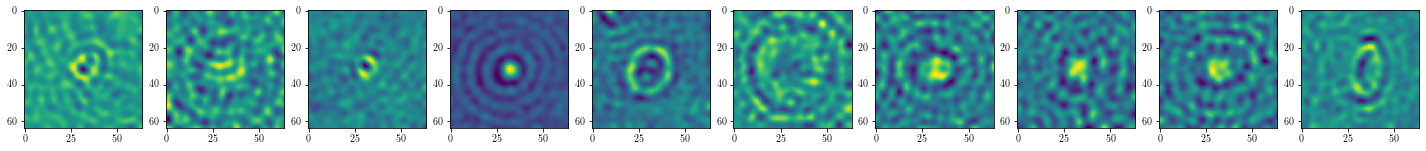

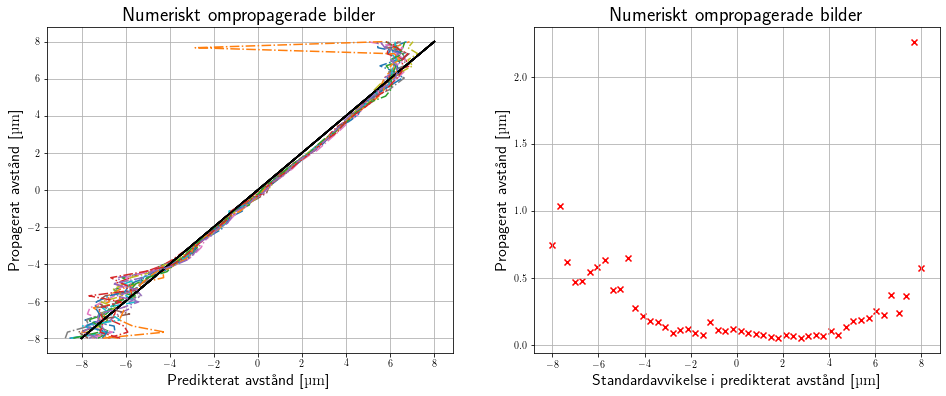

Creating corrected traces 

  0%|          | 0/648 [00:00<?, ?it/s]

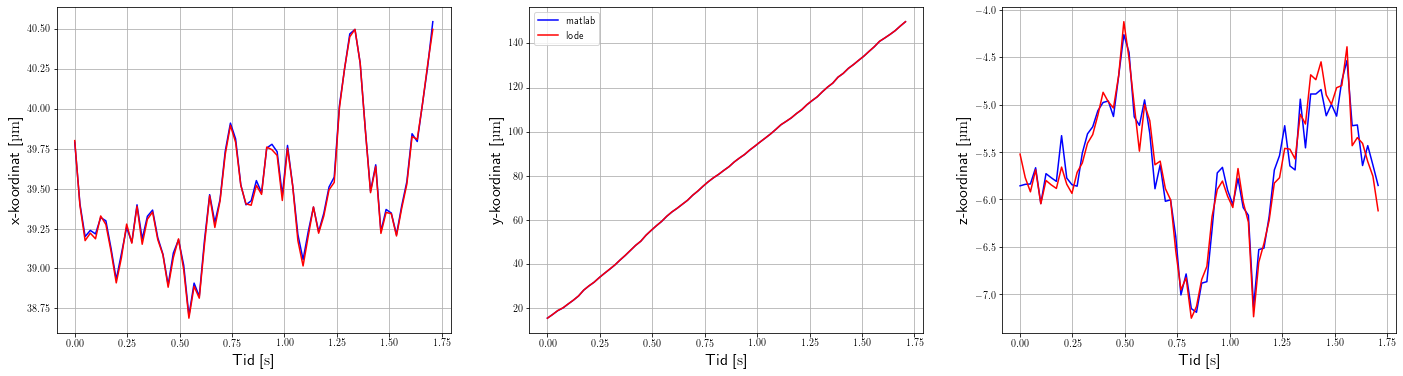

 15%|█▌        | 100/648 [00:14<01:24,  6.47it/s]

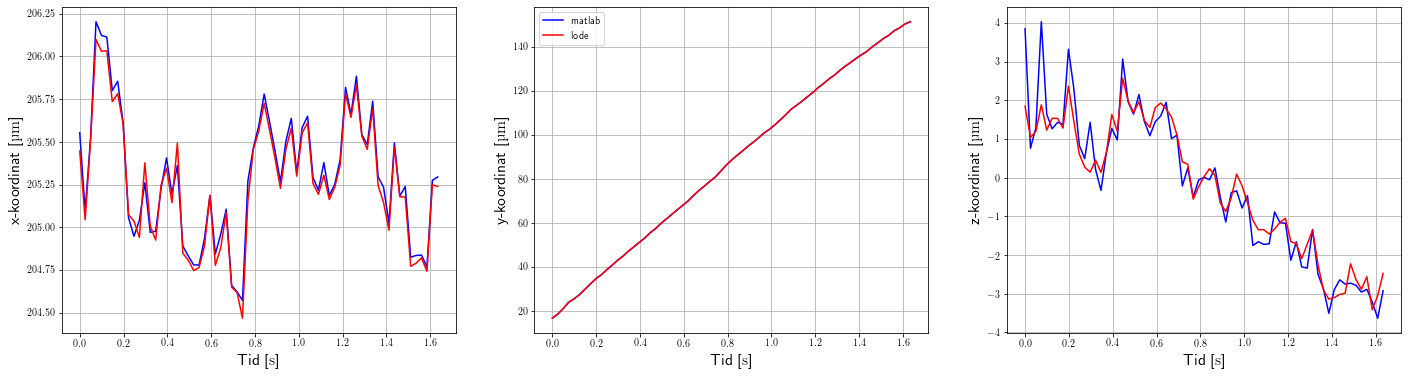

 31%|███       | 200/648 [00:36<01:03,  7.10it/s]

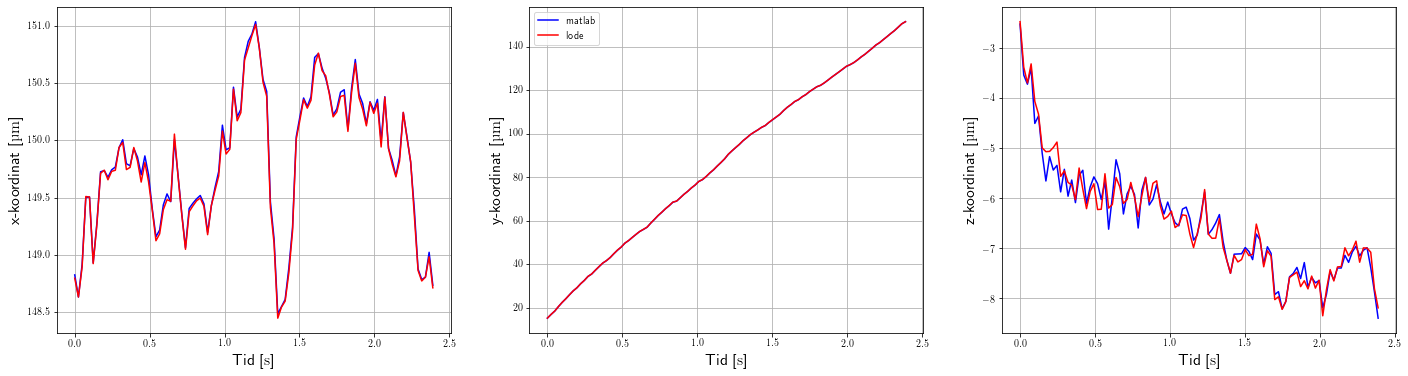

 46%|████▋     | 300/648 [00:58<00:54,  6.40it/s]

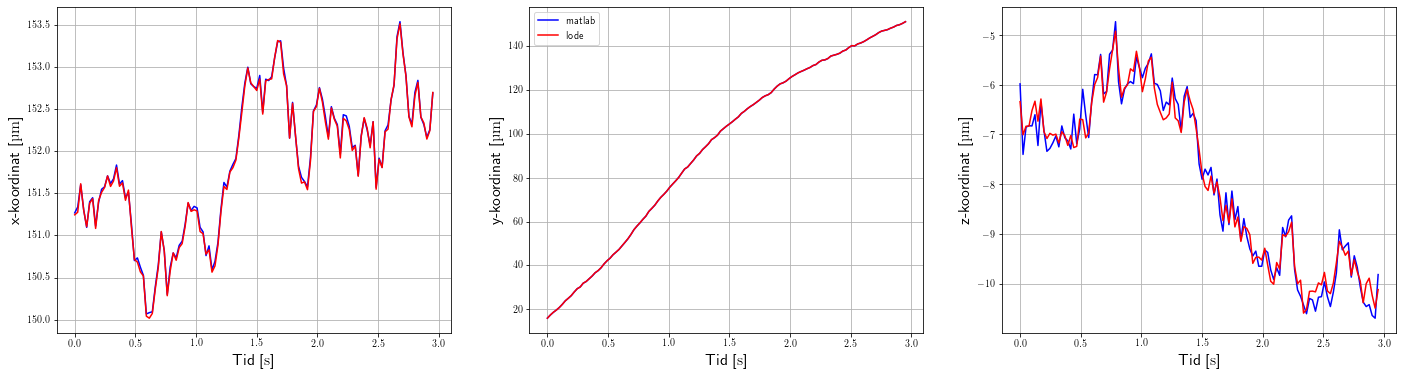

 62%|██████▏   | 400/648 [01:20<00:33,  7.42it/s]

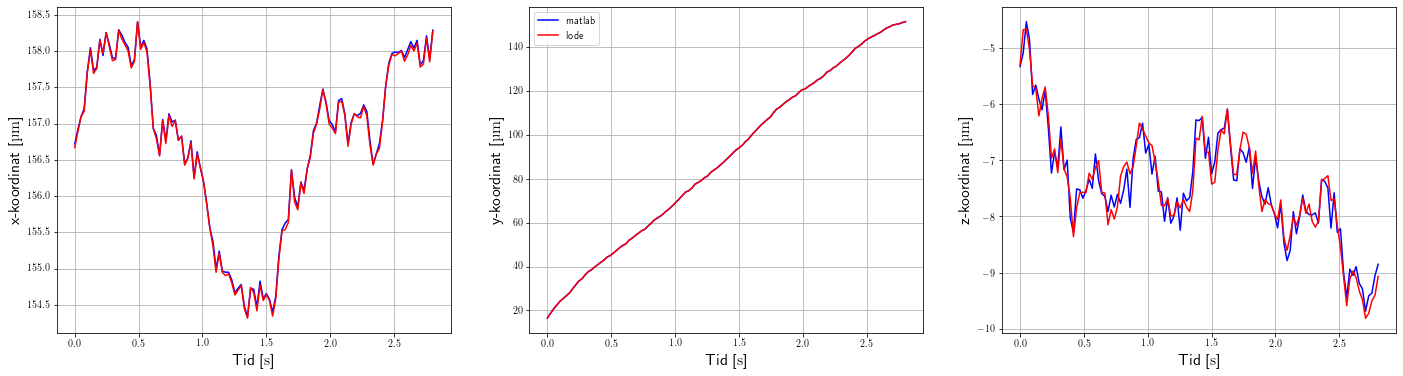

 77%|███████▋  | 500/648 [01:42<00:17,  8.53it/s]

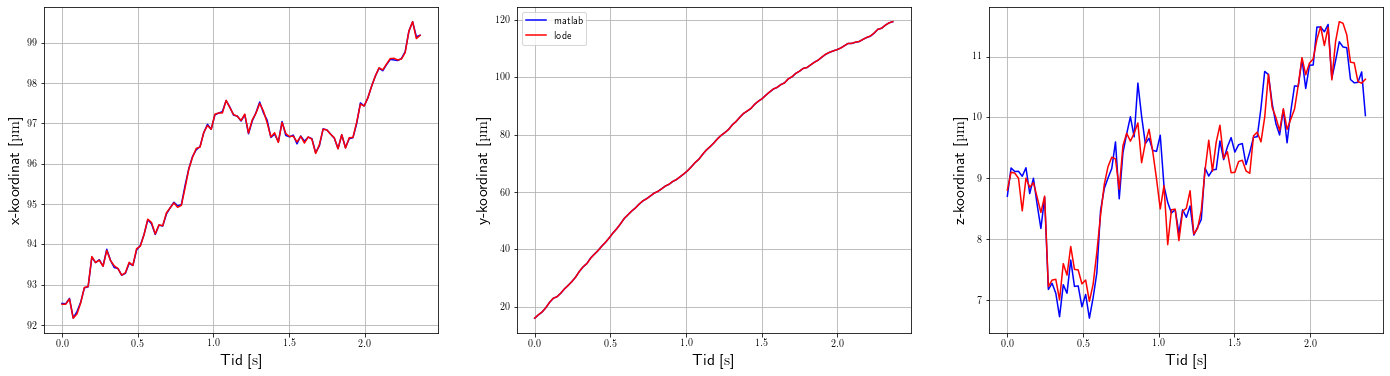

 93%|█████████▎| 600/648 [02:04<00:07,  6.40it/s]

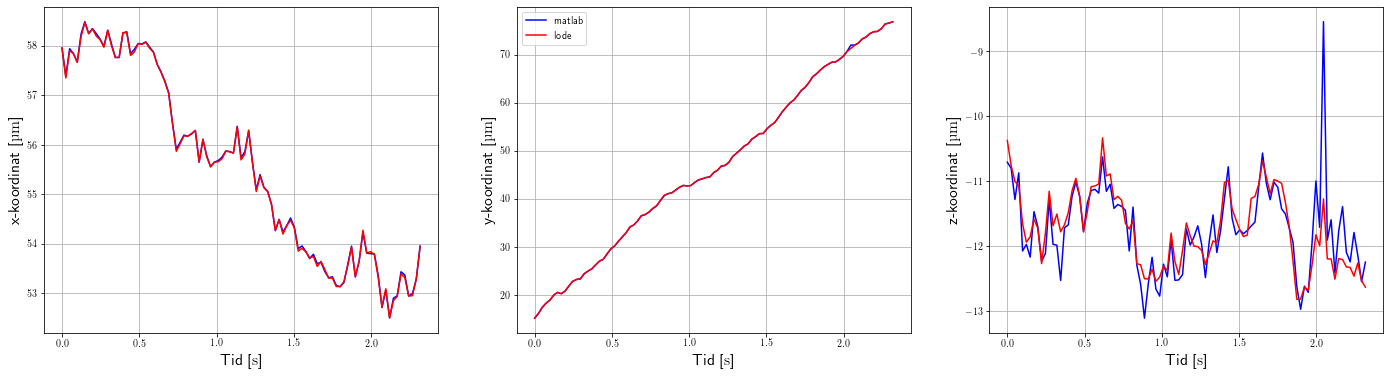

100%|██████████| 648/648 [02:20<00:00,  4.62it/s]


OPTIMAL Z_MULT: 0.9931400799327097
Median av sigma_z^2: 0.015749628309270472


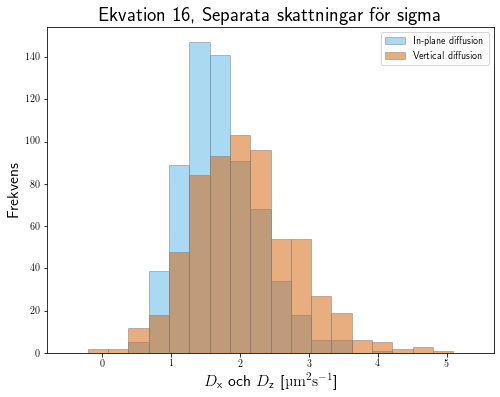

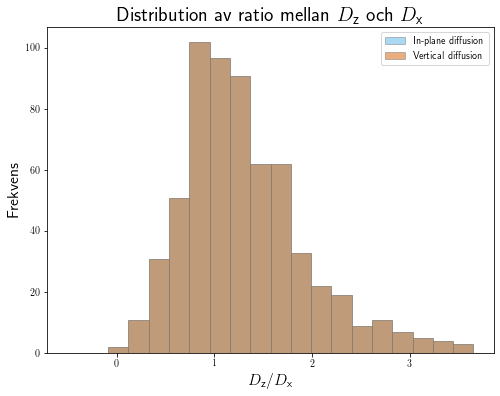

nz/nx interval: (1.091, 1.139) (95.0%)
Expected n_oil/n_medium: 1.125
Joined 25wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat with 25wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat
Loading file: 25wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

100%|██████████| 1000/1000 [00:28<00:00, 35.32it/s]


Number of traces discarded because of non-constant time-steps: 262


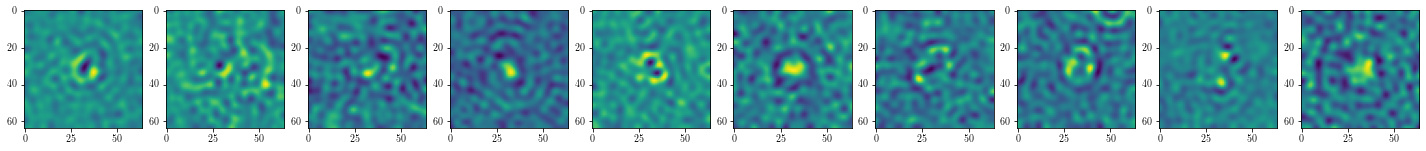

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


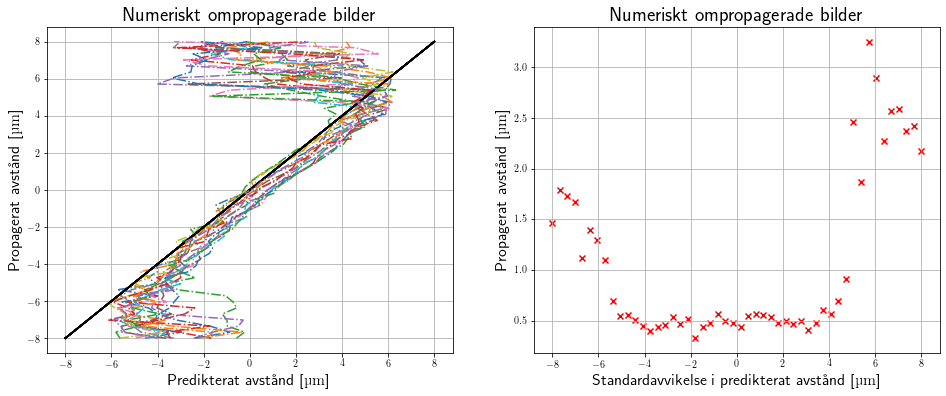

Creating corrected traces 

  0%|          | 0/565 [00:00<?, ?it/s]

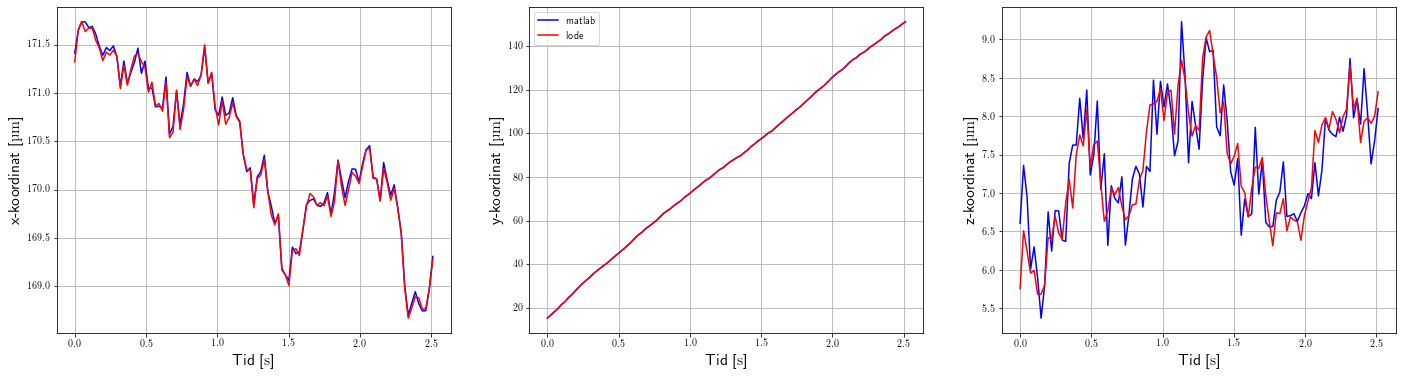

 18%|█▊        | 100/565 [00:17<01:07,  6.93it/s]

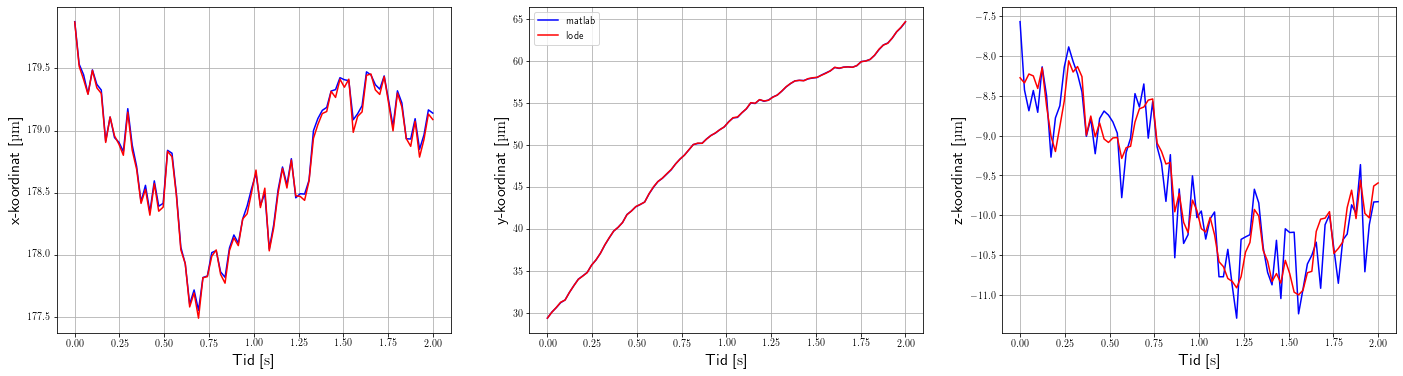

 35%|███▌      | 200/565 [00:42<01:04,  5.66it/s]

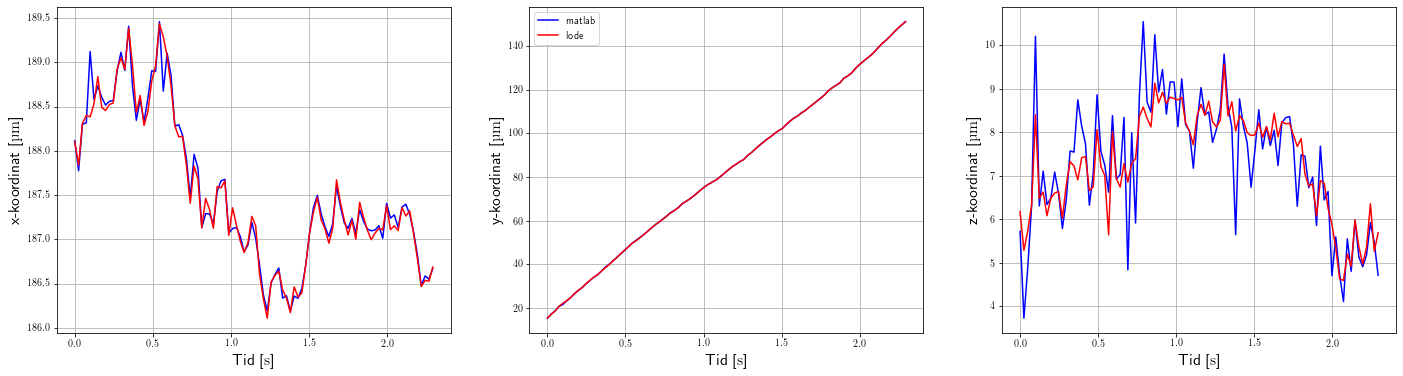

 53%|█████▎    | 300/565 [01:06<00:50,  5.26it/s]

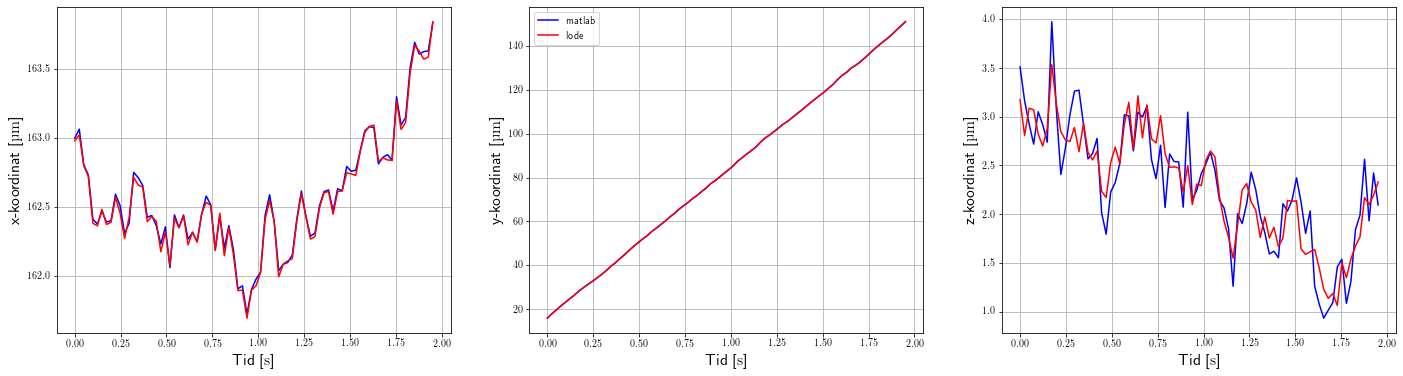

 71%|███████   | 400/565 [01:26<00:22,  7.27it/s]

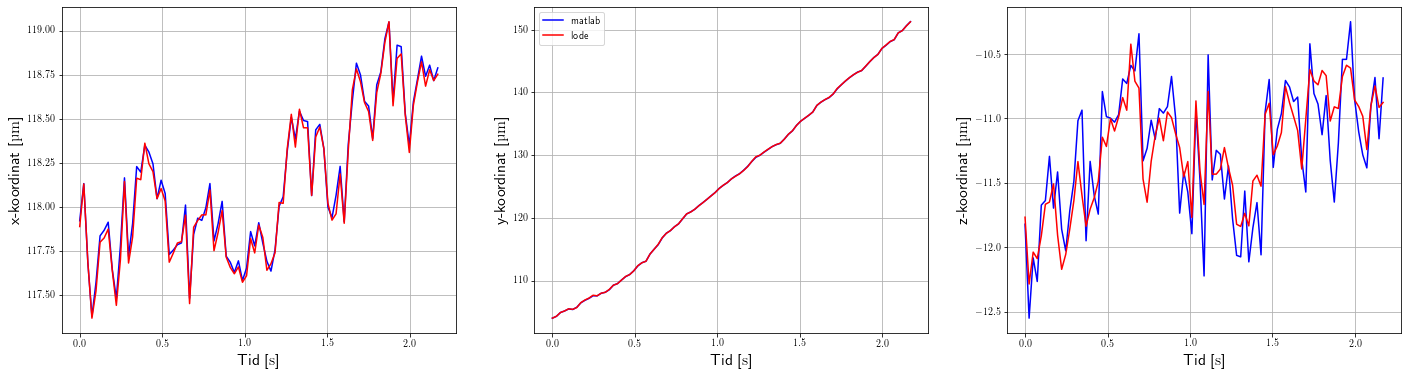

 88%|████████▊ | 500/565 [01:49<00:14,  4.64it/s]

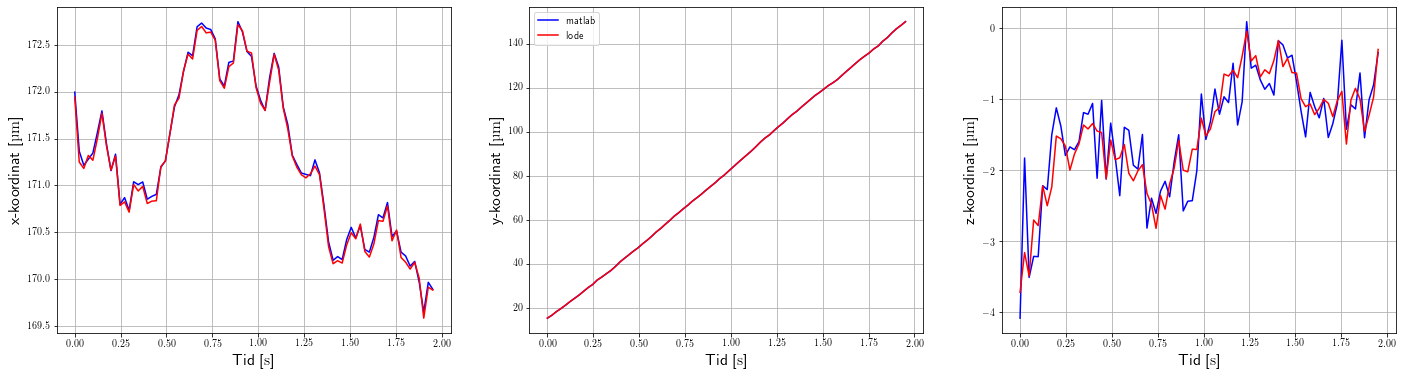

100%|██████████| 565/565 [02:01<00:00,  4.67it/s]


OPTIMAL Z_MULT: 1.0535016669504977
Median av sigma_z^2: 0.022320100491253398


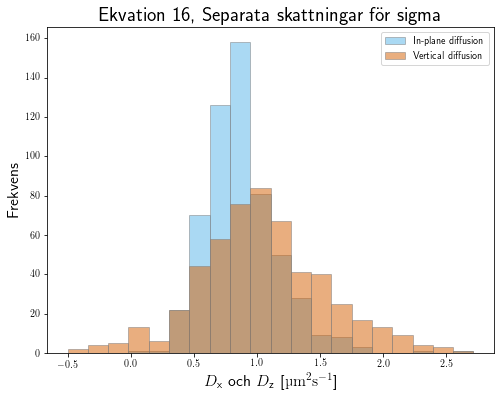

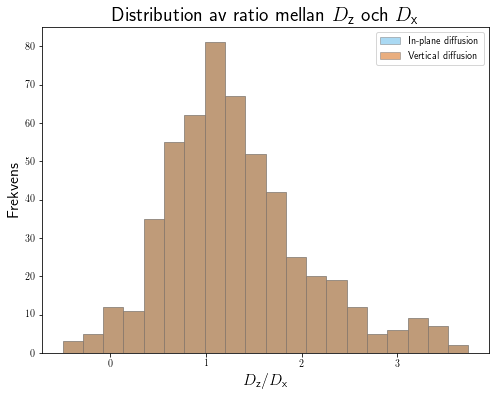

nz/nx interval: (1.076, 1.128) (95.0%)
Expected n_oil/n_medium: 1.100
Joined 50wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat with 50wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat
Loading file: 50wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

100%|██████████| 874/874 [00:19<00:00, 45.81it/s]


Number of traces discarded because of non-constant time-steps: 410


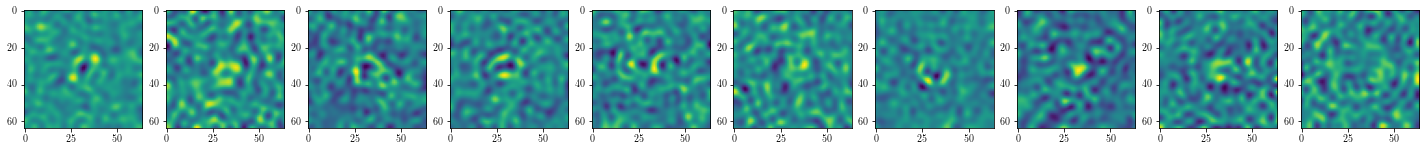

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


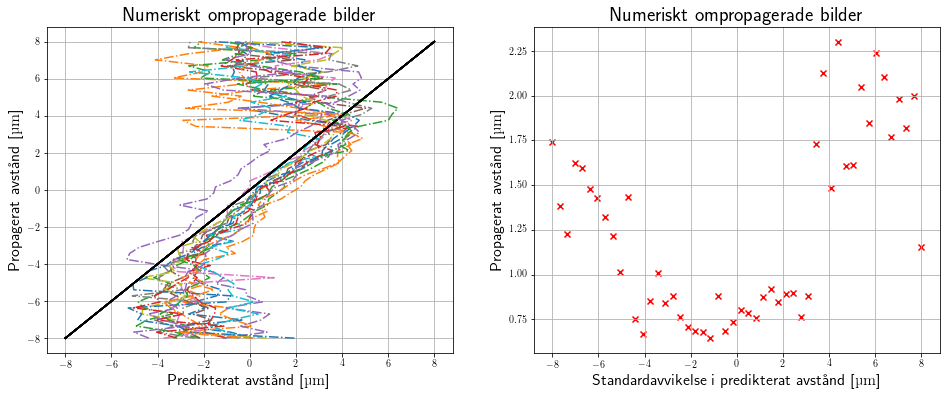

Creating corrected traces 

  0%|          | 0/246 [00:00<?, ?it/s]

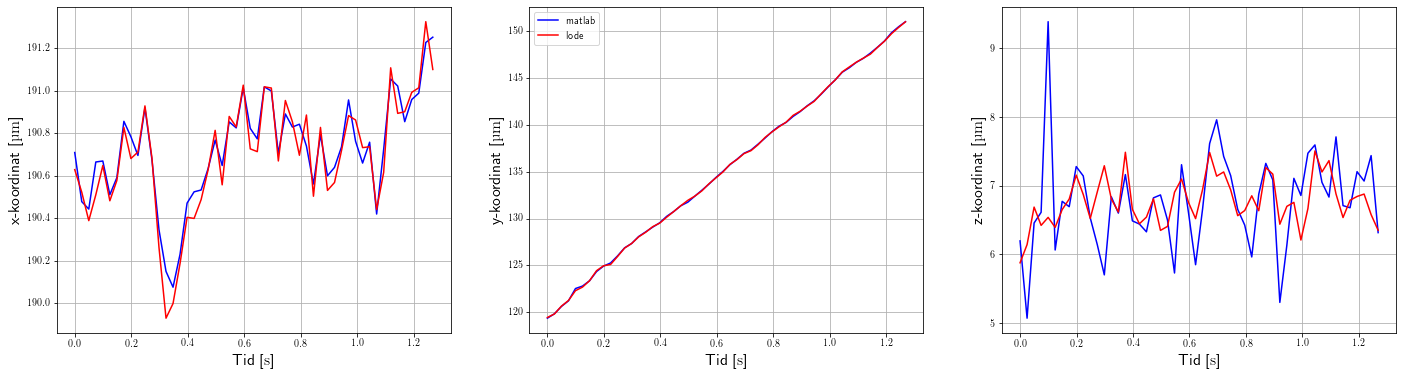

 41%|████      | 100/246 [00:30<00:39,  3.74it/s]

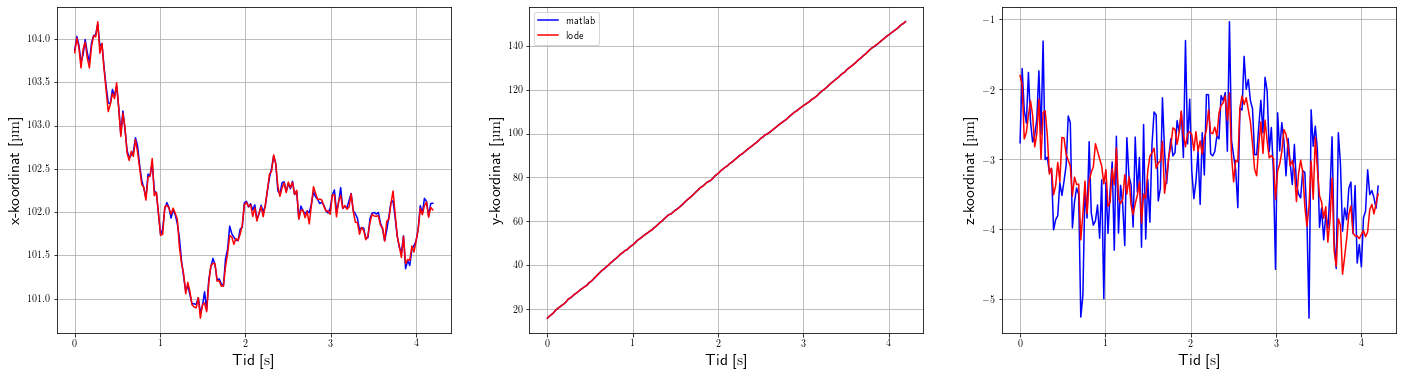

 81%|████████  | 199/246 [01:01<00:13,  3.54it/s]

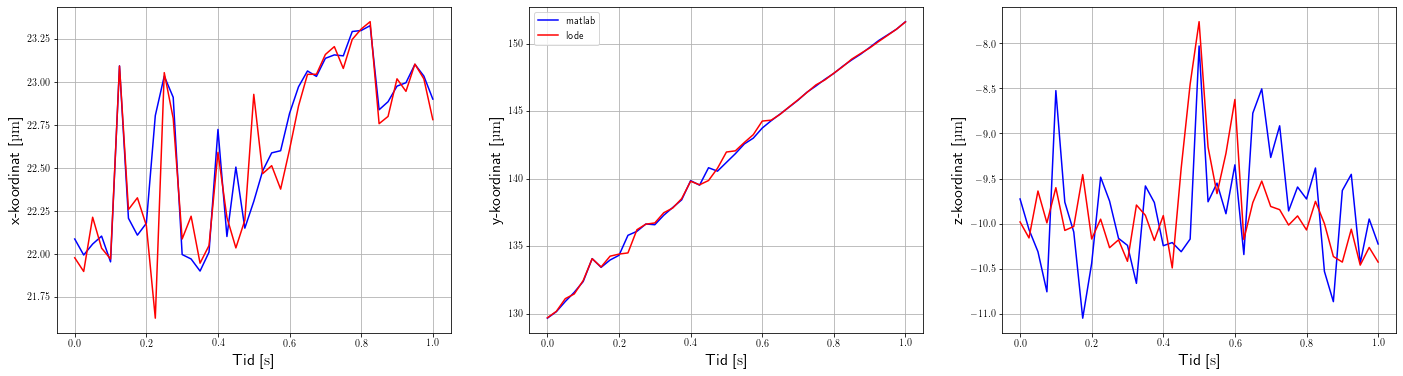

100%|██████████| 246/246 [01:16<00:00,  3.20it/s]


OPTIMAL Z_MULT: 1.0221723159878988
Median av sigma_z^2: 0.061327340344331


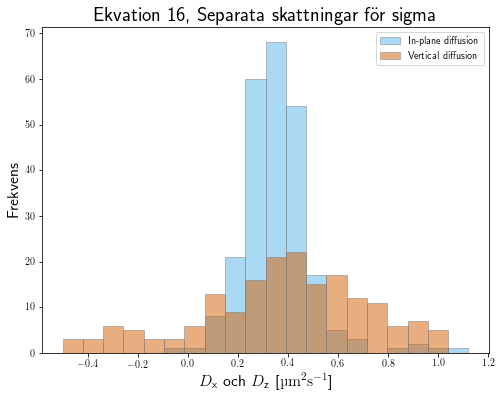

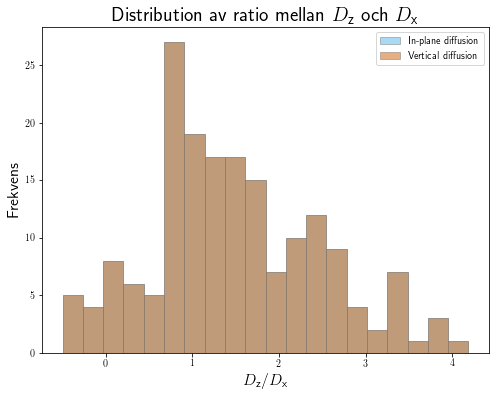

nz/nx interval: (1.059, 1.251) (95.0%)
Expected n_oil/n_medium: 1.073


In [113]:
#http://edge.rit.edu/edge/P13051/public/Research%20Notes/refractive%20index%20glycerin%20water.pdf

%matplotlib inline

drive.mount('/content/drive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def main():
    weights_path = "/content/drive/My Drive/Saved weights/"
    data_path = "/content/drive/My Drive/ny data från Erik/"
    crop_size = 64
    padding = 32
    wavelength = 525e-9
    pixel_size = 114e-9
    num_outputs = 3
    image_size = 64
    delta_time = 1/41
    num_layers = 7
    shortest_trace = 30
    epochs_to_train = 500
    validation_ids = [0]
    conf=0.95

    filenames = !ls 'drive/My Drive/ny data från Erik'
    filenames = sorted([filename for filename in filenames if (".mat" in filename) and ("wGold" in filename)])

    try:
        model = load_weights(weights_path+"/"+str(num_layers), create_model(CustomLayer(), num_layers, image_size, num_outputs))
        print("WEIGHTS LOADED")
        train_flag = False
    except:
        model = create_model(CustomLayer(), num_layers, image_size, num_outputs)
        print("WEIGHTS NOT LOADED, NEW MODEL CREATED")
        train_flag = True

    current_file_index = 0
    while current_file_index < len(filenames):
        file = scipy.io.loadmat(data_path + filenames[current_file_index])['CompletedTraces']

        i=1
        while current_file_index+i<len(filenames) and filenames[current_file_index][:50] in filenames[current_file_index+i]:
            second_file = scipy.io.loadmat(data_path + filenames[current_file_index+i])['CompletedTraces']
            file=np.concatenate((file, second_file), axis=1)
            print(f"Joined {filenames[current_file_index]} with {filenames[current_file_index+i]}")
            i+=1
        current_file_index +=i
        
        file = file[:,:1000]
        print(f"Loading file: {filenames[current_file_index-1]}", end=" ")
        particles_positions, particles_timeseries = extract_pos_and_images(file, shortest_trace=shortest_trace)

        group, equivariance, prop_matrices = create_group(crop_size=crop_size, padding=padding, wavelength=wavelength, pixel_size=pixel_size)
        plot_dataset(create_training_set(particles_timeseries), group, nrows=1)
        if train_flag:
            train_on_particle(model, particles_timeseries, num_outputs, group, equivariance, epochs_to_train, verbose=0) # change verbose to show training progress or not.
            save_weights(weights_path+"/"+str(num_layers), model)
            train_flag = False
        else:
            train_flag = False
        for validation_id in validation_ids:
            plot_consistency(model, particles_timeseries[validation_id], np.linspace(-80,80,50), prop_matrices, padding)

        print(f"Creating corrected traces", end=" ")
        traces_matlab, traces_lode, z_mults = compare_lode_matlab(model, particles_timeseries, particles_positions, verbose=1) # change verbose to plot paths or not.
        print(f"OPTIMAL Z_MULT: {np.median(z_mults)}")
        calculate_diffusion(traces_lode, delta_time, shortest_trace=shortest_trace, conf=conf)
        #calculate_diffusion(traces_matlab, delta_time, shortest_trace=shortest_trace, conf=conf)

        n_glycerin_water = {"0":1.333, "2":1.364, "5": 1.398} #brytningindex för 0, 25 respektive 50 procent glycerin, indexeras med första bokstaven i filnamnet
        print(f"Expected n_oil/n_medium: {1.5/n_glycerin_water[filenames[current_file_index-1][0]]:.3f}")

main()

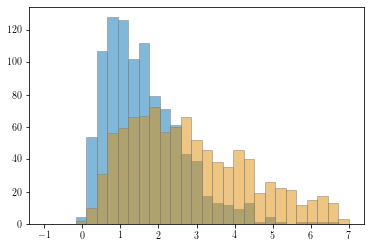

Actual nz/nx 1.875)
Interval: (1.7018198300257812, 2.0673889921232043)
1


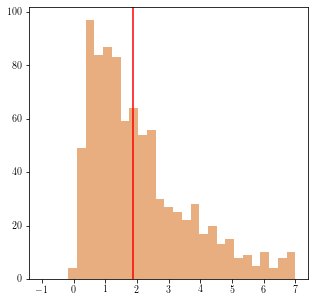

In [114]:
from scipy.stats import chi2, betaprime
bins=np.linspace(-1,7,30)

mu_x = 1.6
mu_z = 3
counter=0
for _ in range(1):
    df = 5
    size=1000

    x = chi2.rvs(df=df, size=size)/df*mu_x
    z = chi2.rvs(df=df, size=size)/df*mu_z

    fig, ax = plt.subplots(1,1)
    ax.hist(x, bins=bins, alpha=0.5, facecolor=seaborn.color_palette("colorblind")[0], edgecolor='grey')
    ax.hist(z, bins=bins, alpha=0.5, facecolor=seaborn.color_palette("colorblind")[1], edgecolor='grey')
    plt.show()

    fig, ax1 = plt.subplots(1,1, figsize=(5,5))
    ax1.hist(z/x, bins=bins, alpha=0.5, facecolor=seaborn.color_palette("colorblind")[3])

    print(f"Actual nz/nx {np.median(mu_z)/np.median(mu_x):.3f})")
    ax1.axvline(mu_z/mu_x, color='r')
    low, high = confint(z,x,0.99)
    if low < mu_z/mu_x < high:
        counter += 1
    print(f"Interval: ({low}, {high})")
print(counter)

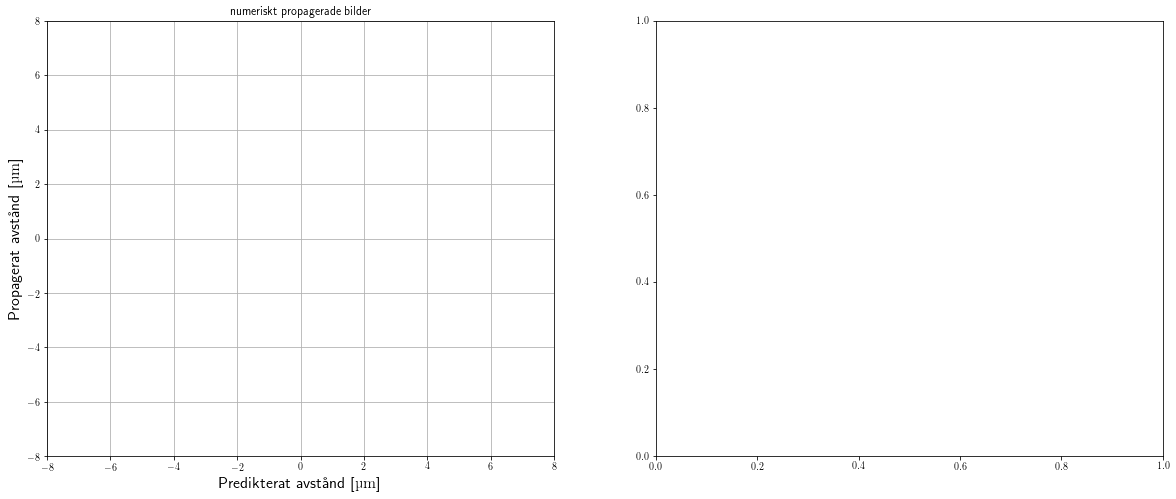

In [115]:
 fig, axs = plt.subplots(1,2, figsize=(20,8))
axs[0].set_title("numeriskt propagerade bilder")
axs[0].set_xlabel(r"Predikterat avstånd [\SI{}{\micro\meter}]", fontsize=16)
axs[0].set_ylabel(r"Propagerat avstånd [\SI{}{\micro\meter}]", fontsize=16)
axs[0].set_xticks(np.linspace(-80, 80, 9)/10)
axs[0].set_yticks(np.linspace(-80, 80, 9)/10)
axs[0].grid(True)